In tutorial 1, we considered why our Constant _Regularization_scheme was sub-optimal. Diffferent regions of the source demand different levels of regularization, motivating a _Regularization_scheme which adapts to the reconstructed source’s surface brightness.

This raises the same question as before, how do we adapt our _Regularization_scheme to the source before we’ve reconstructed it? Just like in the last tutorial, we’ll use a model image of a strongly lensed source from a previous phase of the pipeline that we’ve begun calling the ‘hyper-galaxy-image’.

In [1]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [2]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('Exponential.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solMass/u.pc**2)                        #Surface Density in M_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Mass_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                 #Total mass per gaussian component in M_sun




#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                       #Inclination angle in rad
M0 = Mass_mge/10                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad

np.sum(M0)

<Quantity 1.79619688e+09 solMass>

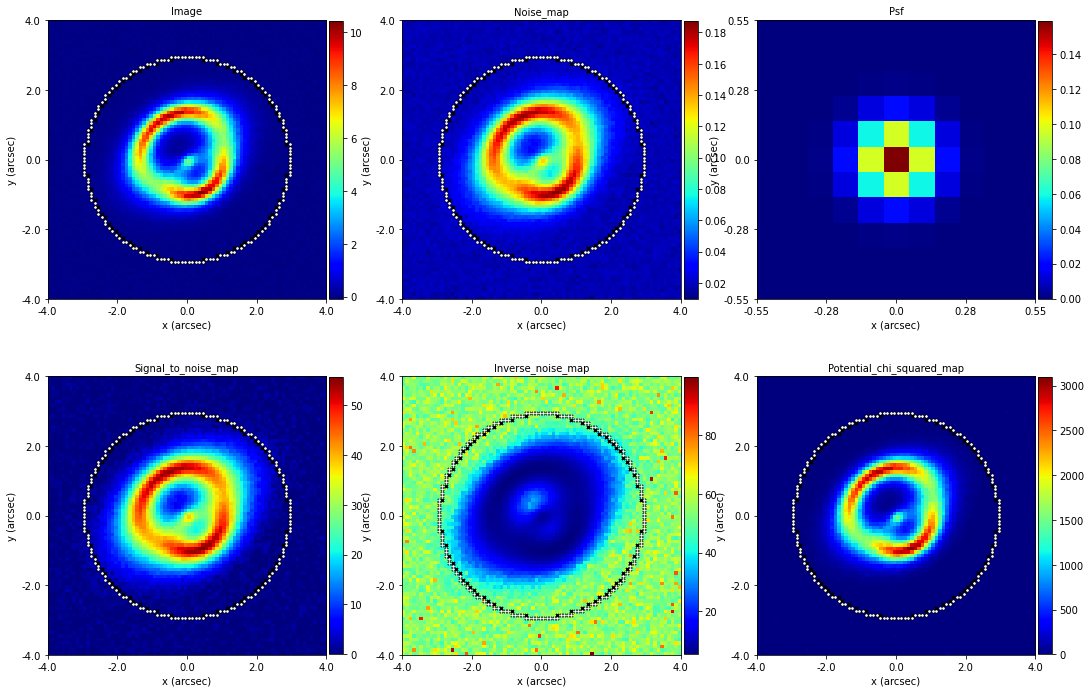

In [3]:
dataset_type = "MGE"
dataset_name = "Data"
dataset_path = f"{workspace_path}/howtolens/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageExp.fits",
    noise_map_path=f"{dataset_path}/NoiseExp.fits",
    psf_path=f"{dataset_path}/PSFExp.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=3 ,centre=(0, 0)
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)


Next, we’re going to fit the image using our magnification based grid. To perform the fits, we’ll use a convenience function to fit the lens data we simulated above.

In [4]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

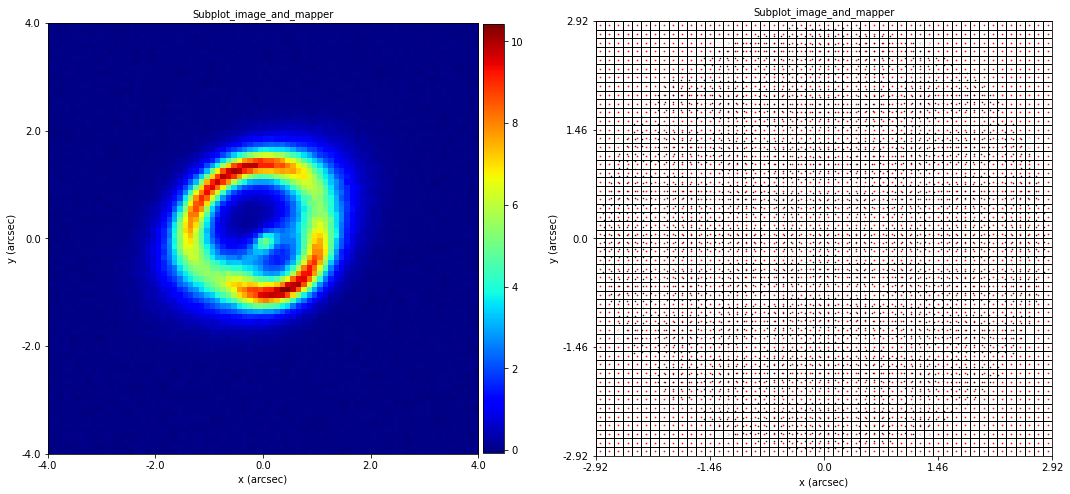

In [5]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

In [6]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=7.0),
)

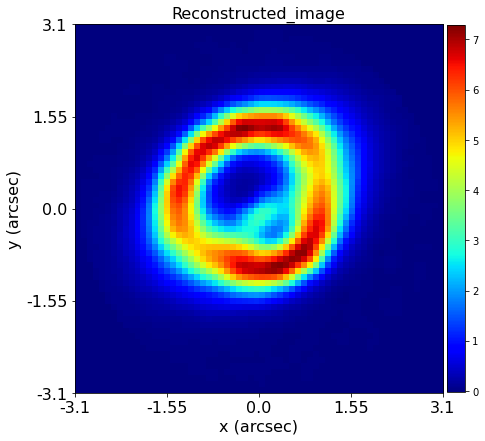

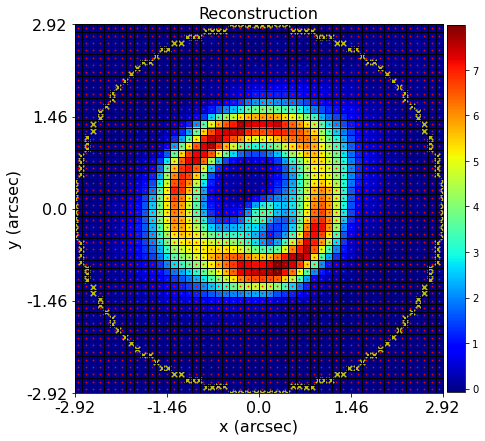

In [7]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=False))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_grid=False),
)

####################################################################################################################

In [81]:
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.MGE(centre=(0.0, 0.0), einstein_radius=1.8)
    mass_profile.MGE_comps(M=M0, sigma=sigma0, q=q0, z_l=z_lens, z_s=z_source)
    
    lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


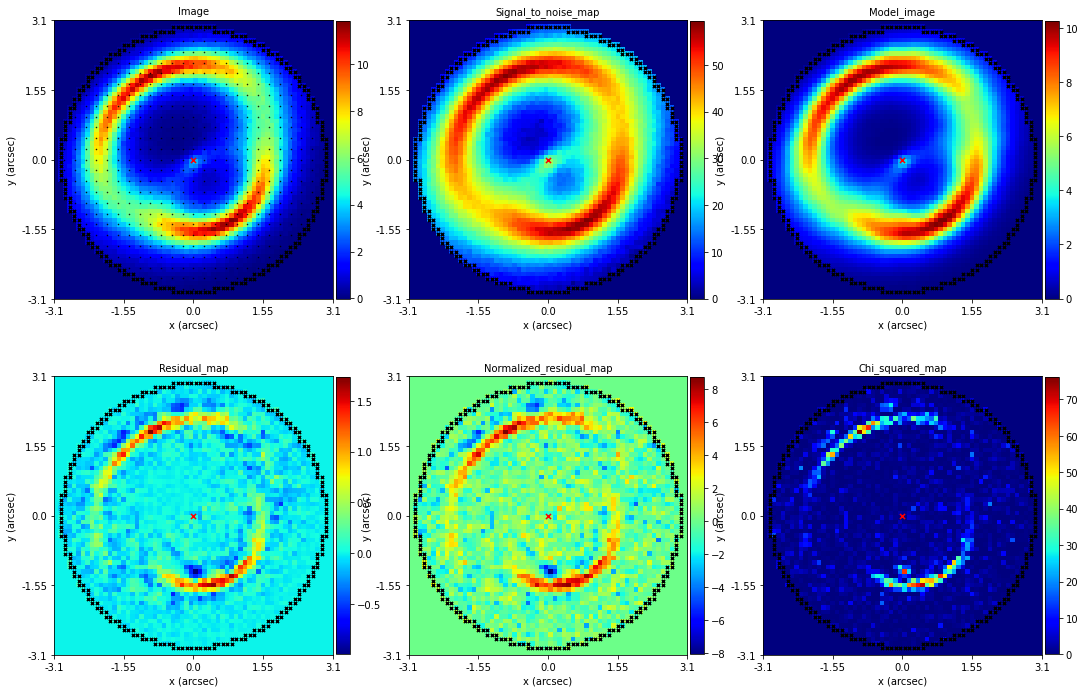

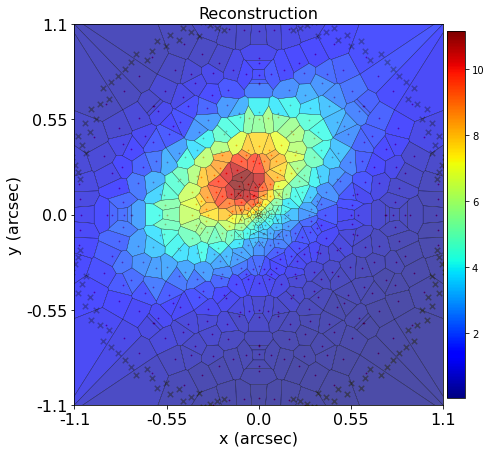

Evidence using adaptive _Regularization_=  -16026.260495741102


In [82]:
source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(25, 25)),
    regularization=al.reg.Constant(coefficient=7),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence

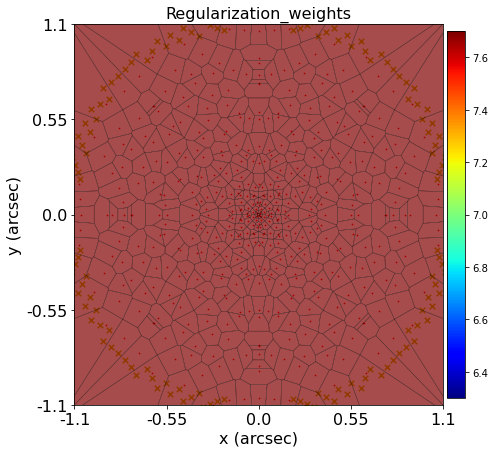

In [84]:
aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

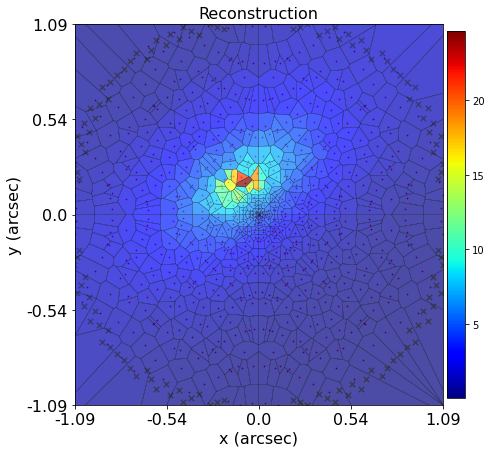

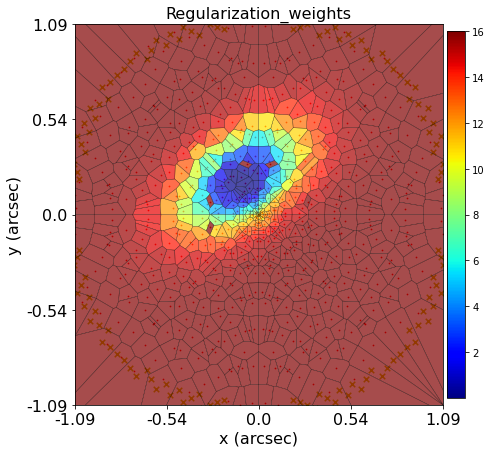

In [85]:
hyper_image = fit.model_image.in_1d_binned

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.05, outer_coefficient=4, signal_scale=3.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)


In [86]:
print("Evidence using constant _Regularization_= ", frist_log)
print("Evidence using adaptive _Regularization_= ", fit.log_evidence)

Evidence using constant _Regularization_=  -16026.260495741102
Evidence using adaptive _Regularization_=  -68574.89104153041


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


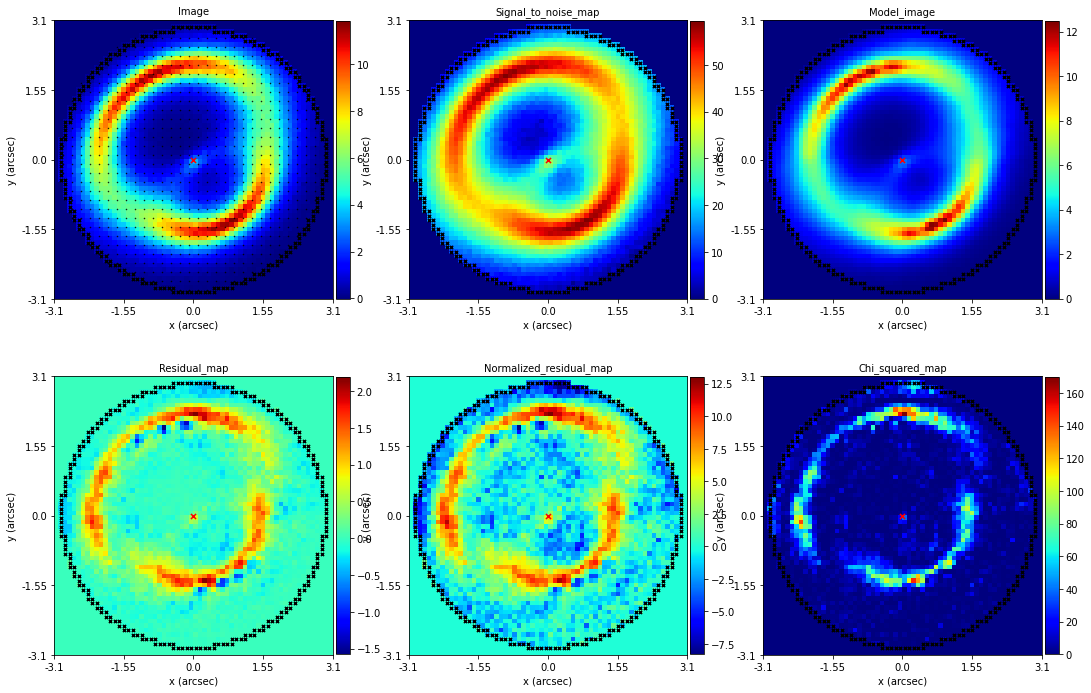

In [87]:
aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

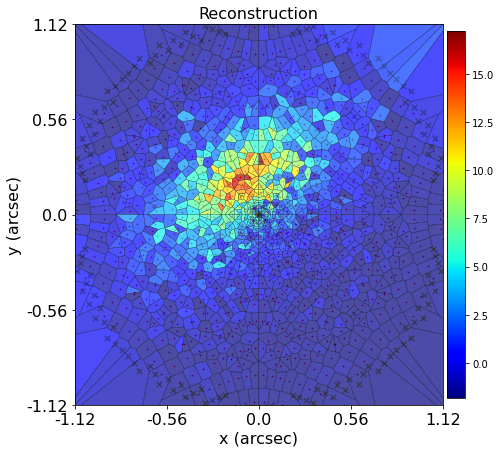

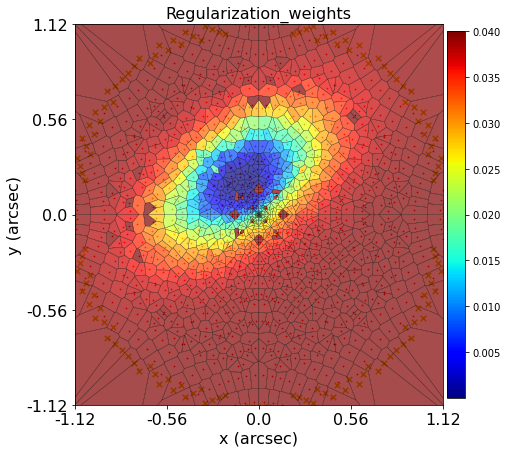

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


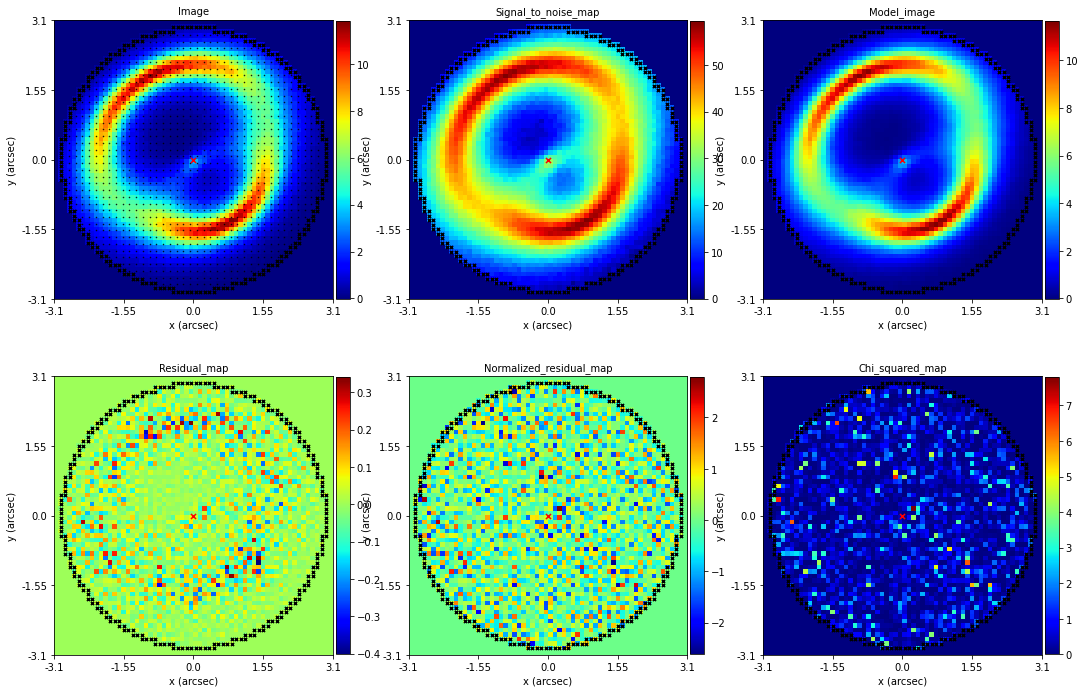

Evidence using adaptive _Regularization_=  -441.6482862687117


In [88]:
source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(40, 40)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.Inversion.regularization_weights(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)